# Import libraries & mount drive:

In [ ]:
pip install neptune-client

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from PIL import Image
import os
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
import time
import neptune

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
from google.colab import drive
drive.mount('/content/data')

In [ ]:
%cd '/content/data/MyDrive/hw2 data'

# Q2.c

In [6]:
def Get_Data(file_name):
    images = []
    labels = []
    with open(file_name, 'r') as f:
        for line in f:
            line_ls = line.split()
            L = len(line_ls)
            if L == 3: #same person
                first_person, first_index, second_index = line_ls
                second_person = first_person
                labels.append(1)
            elif L == 4: #diffrent person
                first_person, first_index, second_person, second_index = line_ls
                labels.append(0)
            else:
              continue
            first_img = f'lfw2/{first_person}/{first_person}_{"{:04d}".format(int(first_index))}.jpg'
            second_img = f'lfw2/{second_person}/{second_person}_{"{:04d}".format(int(second_index))}.jpg'
            images.append((first_img, second_img))

    return np.array(images), np.array(labels)

In [7]:
train_file = 'pairsDevTrain.txt'
test_file = 'pairsDevTest.txt'

In [8]:
train_data = Get_Data(train_file)

# Calculate the length of the ndarray
length = len(train_data[1])

# Count the occurrences of each unique value
unique_vals, counts = np.unique(train_data[1], return_counts=True)

# Display the length and the counts
print("Number of examples:", length)
print("Counts of each value:")
for val, count in zip(unique_vals, counts):
    print(f"{val}: {count}")

Number of examples: 2200
Counts of each value:
0: 1100
1: 1100


In [9]:
test_data = Get_Data(test_file)

# Calculate the length of the ndarray
length = len(test_data[1])

# Count the occurrences of each unique value
unique_vals, counts = np.unique(test_data[1], return_counts=True)

# Display the length and the counts
print("Number of examples:", length)
print("Counts of each value:")
for val, count in zip(unique_vals, counts):
    print(f"{val}: {count}")

Number of examples: 1000
Counts of each value:
0: 500
1: 500


#Q3

In [12]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=10),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(64),
            nn.Dropout(0.5))  # Add dropout with a probability of 0.5

        self.cnn2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=7),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(128),
            nn.Dropout(0.5))  # Add dropout with a probability of 0.5

        self.cnn3 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(128),
            nn.Dropout(0.5))  # Add dropout with a probability of 0.5

        self.cnn4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.Dropout(0.5))  # Add dropout with a probability of 0.5

        self.fc1 = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096),
            nn.Sigmoid(),
            nn.Dropout(0.5))  # Add dropout with a probability of 0.5

        self.fc2 = nn.Sequential(
            nn.Linear(4096, 1),
            nn.Sigmoid())

        #Weight initialization as in the paper:
        self.cnn1[0].weight.data.normal_(0,0.01)
        self.cnn1[0].bias.data.normal_(0.5,0.01)

        self.cnn2[0].weight.data.normal_(0,0.01)
        self.cnn2[0].bias.data.normal_(0.5,0.01)

        self.cnn3[0].weight.data.normal_(0,0.01)
        self.cnn3[0].bias.data.normal_(0.5,0.01)

        self.cnn4[0].bias.data.normal_(0.5,0.01)
        self.cnn4[0].weight.data.normal_(0,0.01)

        self.fc1[0].bias.data.normal_(0.5,0.01)
        self.fc1[0].weight.data.normal_(0,0.02)

        self.fc2[0].bias.data.normal_(0.5,0.01)
        self.fc2[0].weight.data.normal_(0,0.02)

    def forward(self, in1, in2):
        in1 = self.cnn1(in1)
        in1 = self.cnn2(in1)
        in1 = self.cnn3(in1)
        in1 = self.cnn4(in1)
        in1 = in1.view(in1.size()[0], -1)
        out1 = self.fc1(in1)

        in2 = self.cnn1(in2)
        in2 = self.cnn2(in2)
        in2 = self.cnn3(in2)
        in2 = self.cnn4(in2)
        in2 = in2.view(in2.size(0), -1)
        out2 = self.fc1(in2)

        L1 = torch.abs(out1-out2)
        output = self.fc2(L1)

        return output

In [13]:
def train(train_loader, model, loss_function, optimizer, scheduler, valid_loader=None):
    size = len(train_loader.dataset)
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0

    # Start the timer
    start_time = time.time()

    for i, ((img1, img2), label) in enumerate(train_loader):
        img1, img2, y = img1.to(device), img2.to(device), label.view(-1, 1).float().to(device)

        # Forward
        prediction = model.forward(img1, img2)

        # Backward
        loss = loss_function(prediction, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        binary_predictions = torch.where(prediction > 0.5, torch.tensor(1.0).to(device), torch.tensor(0.0).to(device))
        batch_accuracy = (binary_predictions == y).type(torch.float).sum().item() / len(y)
        running_accuracy += batch_accuracy

        if (i + 1) % 5 == 0:
            running_loss /= 5
            running_accuracy /= 5
            current = i * len(img1)
            run['training/loss'].log(running_loss)
            run['training/accuracy'].log(running_accuracy)
            print(f"\nStep: {current}/{size} Avg accuracy: {running_accuracy :>0.6f} Avg loss: {running_loss:>5f}")

            running_loss, running_accuracy = 0, 0

    if valid_loader:
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            val_accuracy = 0.0
            for j, ((val_img1, val_img2), val_label) in enumerate(valid_loader):
                val_img1, val_img2, val_y = val_img1.to(device), val_img2.to(device), val_label.view(-1, 1).float().to(device)
                val_pred = model.forward(val_img1, val_img2)
                val_loss += loss_function(val_pred, val_y).item()

                val_binary_predictions = torch.where(val_pred > 0.5, torch.tensor(1.0).to(device), torch.tensor(0.0).to(device))
                val_batch_accuracy = (val_binary_predictions == val_y).type(torch.float).sum().item() / len(val_y)
                val_accuracy += val_batch_accuracy

            val_loss /= len(valid_loader)
            val_accuracy /= len(valid_loader)

        # Log validation metrics to Neptune
        run['validation/loss'].log(val_loss)
        run['validation/accuracy'].log(val_accuracy)
        print(f"\nValidation: Avg accuracy: {val_accuracy:>0.5f} Avg loss: {val_loss:>5f}")

        model.train()
    scheduler.step()

    # Stop the timer
    end_time = time.time()
    # Calculate convergence time
    convergence_time = end_time - start_time
    print(f"\nConvergence Time is {convergence_time}")

    return model, val_loss

In [14]:
def test(dataloader, model, loss_func, test: bool, device='cuda'):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    total_loss, total_correct = 0, 0
    with torch.no_grad():
        for i, ((img1, img2), label) in enumerate(dataloader):
            img1, img2, y = img1.to(device), img2.to(device), label.view(-1, 1).float().to(device)
            pred = model(img1, img2)
            total_loss += loss_func(pred, y).item()
            binarized_preds = (pred > 0.5).type(torch.float)
            total_correct += (binarized_preds == y).type(torch.float).sum().item()

    avg_loss = total_loss / num_batches
    accuracy = total_correct / size
    test_or_validation_string = "Test" if test else "Validation"
    print(f"{test_or_validation_string}: Accuracy: {accuracy:.5f}, Avg loss: {avg_loss:.5f}")

    run[f'{test_or_validation_string.lower()}/loss'].log(avg_loss)
    run[f'{test_or_validation_string.lower()}/accuracy'].log(accuracy)

    return accuracy

#Q4

In [15]:
class LFWDataset(Dataset):
    def __init__(self, img_paths, lbls, transform):
        self.img_paths, self.lbls = img_paths, lbls
        self.transform = transform
    def __len__(self):
        return len(self.lbls)
    def __getitem__(self, ind):
        label = self.lbls[ind]
        img_path1, img_path2=self.img_paths[ind]
        img1=self.transform(Image.open(img_path1))
        img2=self.transform(Image.open(img_path2))
        return (img1, img2), label

In [16]:
# Split train Dataset into train and valid
def train_val_test_split(batch_size):
  train_imgs_paths, train_lbls = Get_Data(train_file)
  shuffled_indices = np.arange(len(train_imgs_paths))
  np.random.shuffle(shuffled_indices)
  valid_size = int(len(train_imgs_paths) * 0.15)
  (train_imgs_paths, train_lbls), (valid_imgs_paths, valid_lbls) = (train_imgs_paths[valid_size:], train_lbls[valid_size:]), (train_imgs_paths[:valid_size], train_lbls[:valid_size])

  train_dataset=LFWDataset(train_imgs_paths, train_lbls, transform=transforms.Compose([transforms.Resize(105), transforms.ToTensor()]))
  train_dataloader=DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

  valid_dataset=LFWDataset(valid_imgs_paths, valid_lbls, transform=transforms.Compose([transforms.Resize(105), transforms.ToTensor()]))
  valid_dataloader=DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

  test_imgs_paths, test_lbls = Get_Data(test_file)
  test_dataset=LFWDataset(test_imgs_paths, test_lbls, transform=transforms.Compose([transforms.Resize(105), transforms.ToTensor()]))
  test_dataloader=DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

  return train_dataloader, valid_dataloader, test_dataloader

In [17]:
def init_model():
  # init model
  model = SiameseNetwork()
  if torch.cuda.is_available():
      model = model.cuda()
  # set Loss function
  loss_function = nn.BCEWithLogitsLoss()

  return model, loss_function

# Experiments

### Ex1 - Multistep	Adam 0.0001 32

In [ ]:
run = neptune.init_run(
    project="linagolan6/DL2New",
    name='New Train-EX1',
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI2Yjk0MDM0MS1iZjNjLTRmN2ItOTUyMS1mZGUyYjljZDMwOTgifQ==",
)

run['params/model'] = 'Multistep Adam 0.009 32'
run['params/dataset'] = 'humen activity'

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/linagolan6/DL2New/e/DLNEW-30


In [ ]:
model, loss_function = init_model()
train_dataloader, valid_dataloader, test_dataloader = train_val_test_split(batch_size = 32)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,10,15])

validation_loss_ls = []
not_improving_loss = 0

for epoch in range(20):
    print(f"Epoch {epoch+1}")
    trained_model, val_loss = train(train_dataloader, model, loss_function, optimizer, scheduler, valid_dataloader)
    validation_loss_ls.append(val_loss)
    if epoch > 5 and val_loss >= validation_loss_ls[-2]:
      not_improving_loss+=1
    else:
      not_improving_loss = 0
    if not_improving_loss >= 5:
      print(f"Validation loss did not improve for 5 epochs. Early stopping at epoch {epoch+1}")
      break

# Save the final trained model
torch.save(trained_model.state_dict(), 'final_model1.pt')

Epoch 1

Step: 128/1870 Avg accuracy: 0.581250 Avg loss: 0.745101

Step: 288/1870 Avg accuracy: 0.606250 Avg loss: 0.708578

Step: 448/1870 Avg accuracy: 0.581250 Avg loss: 0.694214

Step: 608/1870 Avg accuracy: 0.562500 Avg loss: 0.692933

Step: 768/1870 Avg accuracy: 0.606250 Avg loss: 0.693878

Step: 928/1870 Avg accuracy: 0.550000 Avg loss: 0.693583

Step: 1088/1870 Avg accuracy: 0.650000 Avg loss: 0.694129

Step: 1248/1870 Avg accuracy: 0.575000 Avg loss: 0.693126

Step: 1408/1870 Avg accuracy: 0.562500 Avg loss: 0.693572

Step: 1568/1870 Avg accuracy: 0.600000 Avg loss: 0.693323

Step: 1728/1870 Avg accuracy: 0.600000 Avg loss: 0.693760

Validation: Avg accuracy: 0.60729 Avg loss: 0.754853

Convergence Time is 32.09840178489685
Epoch 2

Step: 128/1870 Avg accuracy: 0.587500 Avg loss: 0.693206

Step: 288/1870 Avg accuracy: 0.600000 Avg loss: 0.693279

Step: 448/1870 Avg accuracy: 0.600000 Avg loss: 0.693380

Step: 608/1870 Avg accuracy: 0.550000 Avg loss: 0.693162

Step: 768/1870 

In [ ]:
test(test_dataloader, trained_model, loss_function, test=True)

Test: Accuracy: 0.63102, Avg loss: 0.74673


0.6310160427807486

In [ ]:
run.stop()

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 2 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 2 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/linagolan6/DL2New/e/DLNEW-30/metadata


### Ex2 - Step Adam 0.0001 32

In [ ]:
run = neptune.init_run(
    project="linagolan6/DL2New",
    name='New Train-EX2',
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI2Yjk0MDM0MS1iZjNjLTRmN2ItOTUyMS1mZGUyYjljZDMwOTgifQ==",
)

run['params/model'] = 'Step Adam 0.0001 32'
run['params/dataset'] = 'humen activity'

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/linagolan6/DL2New/e/DLNEW-31


In [ ]:
model, loss_function = init_model()
train_dataloader, valid_dataloader, test_dataloader = train_val_test_split(batch_size = 32)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1)

validation_loss_ls = []

for epoch in range(20):
    print(f"Epoch {epoch+1}")
    trained_model, val_loss = train(train_dataloader, model, loss_function, optimizer, scheduler, valid_dataloader)
    validation_loss_ls.append(val_loss)
    if epoch > 5 and val_loss >= validation_loss_ls[-2]:
      not_improving_loss+=1
    else:
      not_improving_loss = 0
    if not_improving_loss >= 5:
      print(f"Validation loss did not improve for 5 epochs. Early stopping at epoch {epoch+1}")
      break

# Save the final trained model
torch.save(trained_model.state_dict(), 'final_model2.pt')

Epoch 1

Step: 128/1870 Avg accuracy: 0.637500 Avg loss: 0.712001

Step: 288/1870 Avg accuracy: 0.593750 Avg loss: 0.702597

Step: 448/1870 Avg accuracy: 0.581250 Avg loss: 0.694162

Step: 608/1870 Avg accuracy: 0.575000 Avg loss: 0.693676

Step: 768/1870 Avg accuracy: 0.575000 Avg loss: 0.693134

Step: 928/1870 Avg accuracy: 0.631250 Avg loss: 0.693451

Step: 1088/1870 Avg accuracy: 0.550000 Avg loss: 0.693289

Step: 1248/1870 Avg accuracy: 0.525000 Avg loss: 0.693218

Step: 1408/1870 Avg accuracy: 0.575000 Avg loss: 0.693258

Step: 1568/1870 Avg accuracy: 0.600000 Avg loss: 0.693291

Step: 1728/1870 Avg accuracy: 0.643750 Avg loss: 0.693207

Validation: Avg accuracy: 0.62144 Avg loss: 0.746974

Convergence Time is 32.13870096206665
Epoch 2

Step: 128/1870 Avg accuracy: 0.575000 Avg loss: 0.693187

Step: 288/1870 Avg accuracy: 0.562500 Avg loss: 0.693259

Step: 448/1870 Avg accuracy: 0.662500 Avg loss: 0.693206

Step: 608/1870 Avg accuracy: 0.600000 Avg loss: 0.693231

Step: 768/1870 

In [ ]:
test(test_dataloader, trained_model, loss_function, test=True)

Test: Accuracy: 0.62086, Avg loss: 0.74675


0.620855614973262

In [ ]:
run.stop()

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 2 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 2 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/linagolan6/DL2New/e/DLNEW-31/metadata


### Ex3 - Exponential	Adam 0.0001 32

In [ ]:
run = neptune.init_run(
    project="linagolan6/DL2New",
    name='New Train-EX3',
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI2Yjk0MDM0MS1iZjNjLTRmN2ItOTUyMS1mZGUyYjljZDMwOTgifQ==",
)

run['params/model'] = 'Exponential Adam 0.0001 32'
run['params/dataset'] = 'humen activity'

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/linagolan6/DL2New/e/DLNEW-32


In [ ]:
model, loss_function = init_model()
train_dataloader, valid_dataloader, test_dataloader = train_val_test_split(batch_size = 32)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)

validation_loss_ls = []

for epoch in range(20):
    print(f"Epoch {epoch+1}")
    trained_model, val_loss = train(train_dataloader, model, loss_function, optimizer, scheduler, valid_dataloader)
    validation_loss_ls.append(val_loss)
    if epoch > 5 and val_loss >= validation_loss_ls[-2]:
      not_improving_loss+=1
    else:
      not_improving_loss = 0
    if not_improving_loss >= 5:
      print(f"Validation loss did not improve for 5 epochs. Early stopping at epoch {epoch+1}")
      break

# Save the final trained model
torch.save(trained_model.state_dict(), 'final_model3.pt')

Epoch 1

Step: 128/1870 Avg accuracy: 0.406250 Avg loss: 0.816759

Step: 288/1870 Avg accuracy: 0.612500 Avg loss: 0.718609

Step: 448/1870 Avg accuracy: 0.600000 Avg loss: 0.696965

Step: 608/1870 Avg accuracy: 0.562500 Avg loss: 0.695644

Step: 768/1870 Avg accuracy: 0.606250 Avg loss: 0.694129

Step: 928/1870 Avg accuracy: 0.512500 Avg loss: 0.693136

Step: 1088/1870 Avg accuracy: 0.600000 Avg loss: 0.693110

Step: 1248/1870 Avg accuracy: 0.593750 Avg loss: 0.693552

Step: 1408/1870 Avg accuracy: 0.562500 Avg loss: 0.693461

Step: 1568/1870 Avg accuracy: 0.593750 Avg loss: 0.693235

Step: 1728/1870 Avg accuracy: 0.606250 Avg loss: 0.693233

Validation: Avg accuracy: 0.54268 Avg loss: 0.765865

Convergence Time is 32.48023462295532
Epoch 2

Step: 128/1870 Avg accuracy: 0.600000 Avg loss: 0.693397

Step: 288/1870 Avg accuracy: 0.631250 Avg loss: 0.693354

Step: 448/1870 Avg accuracy: 0.618750 Avg loss: 0.693410

Step: 608/1870 Avg accuracy: 0.562500 Avg loss: 0.693235

Step: 768/1870 

In [ ]:
test(test_dataloader, trained_model, loss_function, test=True)

Test: Accuracy: 0.54225, Avg loss: 0.76627


0.5422459893048128

In [ ]:
run.stop()

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 2 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 2 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/linagolan6/DL2New/e/DLNEW-32/metadata


### Ex4 - Multistep	SGD 0.0001 32

In [ ]:
run = neptune.init_run(
    project="linagolan6/DL2New",
    name='New Train-EX4',
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI2Yjk0MDM0MS1iZjNjLTRmN2ItOTUyMS1mZGUyYjljZDMwOTgifQ==",
)

run['params/model'] = 'Multistep SGD 0.0001 32'
run['params/dataset'] = 'humen activity'

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/linagolan6/DL2New/e/DLNEW-36


In [ ]:
model, loss_function = init_model()
train_dataloader, valid_dataloader, test_dataloader = train_val_test_split(batch_size = 32)

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,10,15])

validation_loss_ls = []

for epoch in range(20):
    print(f"Epoch {epoch+1}")
    trained_model, val_loss = train(train_dataloader, model, loss_function, optimizer, scheduler, valid_dataloader)
    validation_loss_ls.append(val_loss)
    if epoch > 5 and val_loss >= validation_loss_ls[-2]:
      not_improving_loss+=1
    else:
      not_improving_loss = 0
    if not_improving_loss >= 5:
      print(f"Validation loss did not improve for 5 epochs. Early stopping at epoch {epoch+1}")
      break

# Save the final trained model
torch.save(trained_model.state_dict(), 'final_model4.pt')

Epoch 1

Step: 128/1870 Avg accuracy: 0.556250 Avg loss: 0.757102

Step: 288/1870 Avg accuracy: 0.562500 Avg loss: 0.724244

Step: 448/1870 Avg accuracy: 0.518750 Avg loss: 0.736448

Step: 608/1870 Avg accuracy: 0.656250 Avg loss: 0.742213

Step: 768/1870 Avg accuracy: 0.600000 Avg loss: 0.758488

Step: 928/1870 Avg accuracy: 0.518750 Avg loss: 0.732264

Step: 1088/1870 Avg accuracy: 0.537500 Avg loss: 0.735313

Step: 1248/1870 Avg accuracy: 0.556250 Avg loss: 0.721240

Step: 1408/1870 Avg accuracy: 0.568750 Avg loss: 0.734372

Step: 1568/1870 Avg accuracy: 0.606250 Avg loss: 0.739272

Step: 1728/1870 Avg accuracy: 0.537500 Avg loss: 0.719040

Validation: Avg accuracy: 0.45029 Avg loss: 0.777763

Convergence Time is 35.35665249824524
Epoch 2

Step: 128/1870 Avg accuracy: 0.512500 Avg loss: 0.711974

Step: 288/1870 Avg accuracy: 0.606250 Avg loss: 0.734705

Step: 448/1870 Avg accuracy: 0.568750 Avg loss: 0.712864

Step: 608/1870 Avg accuracy: 0.618750 Avg loss: 0.730593

Step: 768/1870 

In [ ]:
test(test_dataloader, trained_model, loss_function, test=True)

Test: Accuracy: 0.57059, Avg loss: 0.76422


0.5705882352941176

In [ ]:
run.stop()

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 2 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 2 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/linagolan6/DL2New/e/DLNEW-36/metadata


### EX4b - Multistep SGD 0.009 32

In [ ]:
run = neptune.init_run(
    project="linagolan6/DL2New",
    name='New Train-EX4b',
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI2Yjk0MDM0MS1iZjNjLTRmN2ItOTUyMS1mZGUyYjljZDMwOTgifQ==",
)

run['params/model'] = 'Multistep SGD 0.009 32'
run['params/dataset'] = 'humen activity'

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/linagolan6/DL2New/e/DLNEW-37


In [ ]:
model, loss_function = init_model()
train_dataloader, valid_dataloader, test_dataloader = train_val_test_split(batch_size = 32)

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.009)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,10,15])

validation_loss_ls = []

for epoch in range(20):
    print(f"Epoch {epoch+1}")
    trained_model, val_loss = train(train_dataloader, model, loss_function, optimizer, scheduler, valid_dataloader)
    validation_loss_ls.append(val_loss)
    if epoch > 5 and val_loss >= validation_loss_ls[-2]:
      not_improving_loss+=1
    else:
      not_improving_loss = 0
    if not_improving_loss >= 5:
      print(f"Validation loss did not improve for 5 epochs. Early stopping at epoch {epoch+1}")
      break

# Save the final trained model
torch.save(trained_model.state_dict(), 'final_model4.pt')

Epoch 1

Step: 128/1870 Avg accuracy: 0.500000 Avg loss: 0.762271

Step: 288/1870 Avg accuracy: 0.612500 Avg loss: 0.702443

Step: 448/1870 Avg accuracy: 0.643750 Avg loss: 0.696854

Step: 608/1870 Avg accuracy: 0.581250 Avg loss: 0.694595

Step: 768/1870 Avg accuracy: 0.556250 Avg loss: 0.696533

Step: 928/1870 Avg accuracy: 0.631250 Avg loss: 0.694650

Step: 1088/1870 Avg accuracy: 0.575000 Avg loss: 0.693804

Step: 1248/1870 Avg accuracy: 0.593750 Avg loss: 0.694397

Step: 1408/1870 Avg accuracy: 0.612500 Avg loss: 0.693901

Step: 1568/1870 Avg accuracy: 0.587500 Avg loss: 0.693825

Step: 1728/1870 Avg accuracy: 0.525000 Avg loss: 0.693093

Validation: Avg accuracy: 0.60427 Avg loss: 0.740195

Convergence Time is 31.954218864440918
Epoch 2

Step: 128/1870 Avg accuracy: 0.668750 Avg loss: 0.694865

Step: 288/1870 Avg accuracy: 0.556250 Avg loss: 0.694400

Step: 448/1870 Avg accuracy: 0.568750 Avg loss: 0.693940

Step: 608/1870 Avg accuracy: 0.581250 Avg loss: 0.693570

Step: 768/1870

In [ ]:
test(test_dataloader, trained_model, loss_function, test=True)

Test: Accuracy: 0.58930, Avg loss: 0.72586


0.5893048128342246

In [ ]:
run.stop()

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 2 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 2 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/linagolan6/DL2New/e/DLNEW-37/metadata


### Ex5 - Multistep	SGD 0.009 64

In [ ]:
run = neptune.init_run(
    project="linagolan6/DL2New",
    name='New Train-EX5',
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI2Yjk0MDM0MS1iZjNjLTRmN2ItOTUyMS1mZGUyYjljZDMwOTgifQ==",
)

run['params/model'] = 'Multistep SGD 0.009 64'
run['params/dataset'] = 'humen activity'

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/linagolan6/DL2New/e/DLNEW-39


In [ ]:
model, loss_function = init_model()
train_dataloader, valid_dataloader, test_dataloader = train_val_test_split(batch_size = 64)

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.009)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,10,15])

validation_loss_ls = []

for epoch in range(20):
    print(f"Epoch {epoch+1}")
    trained_model, val_loss = train(train_dataloader, model, loss_function, optimizer, scheduler, valid_dataloader)
    validation_loss_ls.append(val_loss)
    if epoch > 5 and val_loss >= validation_loss_ls[-2]:
      not_improving_loss+=1
    else:
      not_improving_loss = 0
    if not_improving_loss >= 5:
      print(f"Validation loss did not improve for 5 epochs. Early stopping at epoch {epoch+1}")
      break

# Save the final trained model
torch.save(trained_model.state_dict(), 'final_model5.pt')

Epoch 1

Step: 256/1870 Avg accuracy: 0.434375 Avg loss: 0.835357

Step: 576/1870 Avg accuracy: 0.593750 Avg loss: 0.704031

Step: 896/1870 Avg accuracy: 0.540625 Avg loss: 0.696518

Step: 1216/1870 Avg accuracy: 0.612500 Avg loss: 0.697507

Step: 1536/1870 Avg accuracy: 0.581250 Avg loss: 0.695138

Step: 406/1870 Avg accuracy: 0.605357 Avg loss: 0.695221

Validation: Avg accuracy: 0.62128 Avg loss: 0.757588

Convergence Time is 30.428433418273926
Epoch 2

Step: 256/1870 Avg accuracy: 0.550000 Avg loss: 0.694557

Step: 576/1870 Avg accuracy: 0.581250 Avg loss: 0.694765

Step: 896/1870 Avg accuracy: 0.603125 Avg loss: 0.694213

Step: 1216/1870 Avg accuracy: 0.600000 Avg loss: 0.693993

Step: 1536/1870 Avg accuracy: 0.590625 Avg loss: 0.694044

Step: 406/1870 Avg accuracy: 0.601786 Avg loss: 0.693828

Validation: Avg accuracy: 0.59010 Avg loss: 0.731977

Convergence Time is 30.118163585662842
Epoch 3

Step: 256/1870 Avg accuracy: 0.609375 Avg loss: 0.694448

Step: 576/1870 Avg accuracy: 

In [ ]:
test(test_dataloader, trained_model, loss_function, test=True)

Test: Accuracy: 0.58984, Avg loss: 0.72429


0.5898395721925134

In [ ]:
run.stop()

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 2 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 2 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/linagolan6/DL2New/e/DLNEW-39/metadata


### Ex6 - Multistep	SGD 0.009 128

In [ ]:
run = neptune.init_run(
    project="linagolan6/DL2New",
    name='New Train-EX6',
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI2Yjk0MDM0MS1iZjNjLTRmN2ItOTUyMS1mZGUyYjljZDMwOTgifQ==",
)

run['params/model'] = 'Multistep SGD 0.009 128'
run['params/dataset'] = 'humen activity'

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/linagolan6/DL2New/e/DLNEW-41


In [51]:
model, loss_function = init_model()
train_dataloader, valid_dataloader, test_dataloader = train_val_test_split(batch_size = 32)

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.009)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,10,15])

validation_loss_ls = []

for epoch in range(20):
    print(f"Epoch {epoch+1}")
    trained_model, val_loss = train(train_dataloader, model, loss_function, optimizer, scheduler, valid_dataloader)
    validation_loss_ls.append(val_loss)
    if epoch > 5 and val_loss >= validation_loss_ls[-2]:
      not_improving_loss+=1
    else:
      not_improving_loss = 0
    if not_improving_loss >= 5:
      print(f"Validation loss did not improve for 5 epochs. Early stopping at epoch {epoch+1}")
      break

# Save the final trained model
torch.save(trained_model.state_dict(), 'final_model6.pt')

Epoch 1

Step: 128/1870 Avg accuracy: 0.537500 Avg loss: 0.752850

Step: 288/1870 Avg accuracy: 0.637500 Avg loss: 0.704518

Step: 448/1870 Avg accuracy: 0.543750 Avg loss: 0.696950

Step: 608/1870 Avg accuracy: 0.593750 Avg loss: 0.695288

Step: 768/1870 Avg accuracy: 0.643750 Avg loss: 0.697583

Step: 928/1870 Avg accuracy: 0.537500 Avg loss: 0.694684

Step: 1088/1870 Avg accuracy: 0.600000 Avg loss: 0.694846

Step: 1248/1870 Avg accuracy: 0.543750 Avg loss: 0.694135

Step: 1408/1870 Avg accuracy: 0.643750 Avg loss: 0.694317

Step: 1568/1870 Avg accuracy: 0.568750 Avg loss: 0.693759

Step: 1728/1870 Avg accuracy: 0.556250 Avg loss: 0.694226

Validation: Avg accuracy: 0.59958 Avg loss: 0.738736

Convergence Time is 31.82530426979065
Epoch 2

Step: 128/1870 Avg accuracy: 0.606250 Avg loss: 0.693807

Step: 288/1870 Avg accuracy: 0.606250 Avg loss: 0.694177

Step: 448/1870 Avg accuracy: 0.656250 Avg loss: 0.694117

Step: 608/1870 Avg accuracy: 0.593750 Avg loss: 0.693737

Step: 768/1870 

In [ ]:
test(test_dataloader, trained_model, loss_function, test=True)

Test: Accuracy: 0.59037, Avg loss: 0.72932


0.5903743315508021

In [ ]:
run.stop()

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 2 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 2 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/linagolan6/DL2New/e/DLNEW-41/metadata


# Q4.d

In [50]:
model = SiameseNetwork()
model_path = '/content/data/MyDrive/hw2 data/final_model5.pt'
model = torch.load(model_path, map_location=torch.device('cpu'))

Wrong Classification:
truth label = tensor([1.], device='cuda:0')


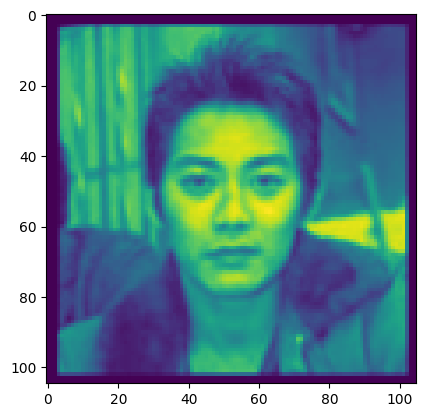

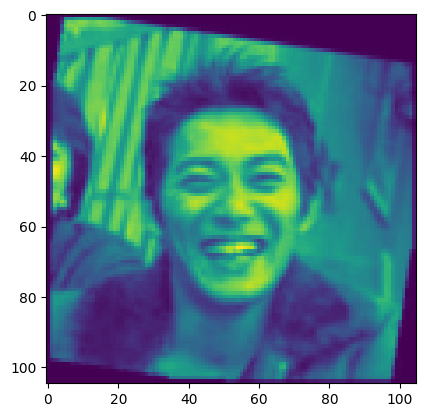

Correct Classification
truth label = tensor([0.], device='cuda:0')


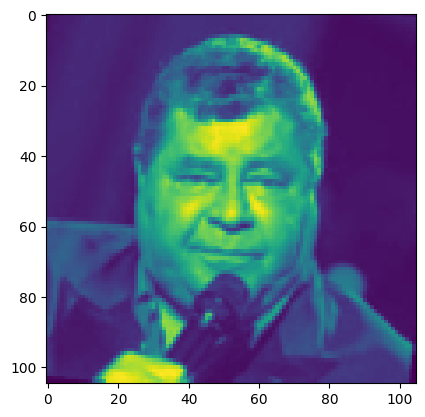

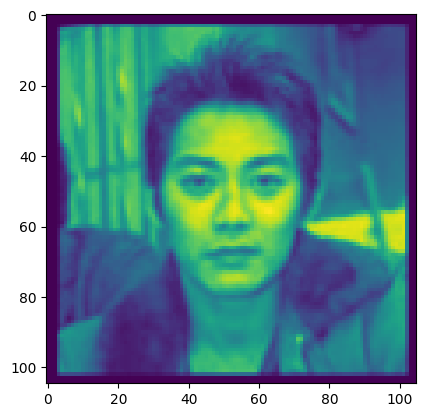

In [53]:
Wrong_Classification, Correct_Classification = False, False

for i, ((img1, img2), label) in enumerate(train_dataloader):
    img1, img2, y = img1.to(device), img2.to(device), label.view(-1, 1).float().to(device)

    # Forward
    prediction = model.forward(img1, img2)

    binarized_preds = (prediction > 0.5).type(torch.float)

    for ind in range(len(prediction)):
      if binarized_preds[ind] == label[ind] and not Correct_Classification:
        print('Wrong Classification:')
        print('truth label =', y[ind])
        plt.figure()
        plt.imshow(img1.cpu().numpy()[ind].squeeze())
        plt.figure()
        plt.imshow(img2.cpu().numpy()[ind].squeeze())
        plt.show()
        Correct_Classification = True

      elif binarized_preds[ind] != label[ind] and not Wrong_Classification:
        print('Correct Classification')
        print('truth label =', y[ind])
        plt.figure()
        plt.imshow(img1.cpu().numpy()[ind].squeeze())
        plt.figure()
        plt.imshow(img2.cpu().numpy()[ind].squeeze())
        plt.show()

        Wrong_Classification = True

    if Wrong_Classification == True and Correct_Classification == True: break